# Examples on constraints on controls

Not only we can constrain the density, we can also constrain the controls i.e. the momentum and the source term. Here, we will show examples on such constraints.

## River constraint
Here, we will consider the constraint of the form
$$ \int_{\Omega} H(t,x) \cdot d\omega_t(x) \geq 0 $$
This constraint constrols the direction of the mass. In particular, if $H(t, x)$ is a constant vector, then the mass can only move in the vectors that has positive inner product. In this example, we have a square grid with a "river" in the middle and on the river, $H(t, x)$ points bottom right, meaning we cannot cross the river straight. 

In [1]:
# Import necessary libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from proximal.dynamicUOT import computeGeodesic, computeGeodesic_inequality
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
from PIL import Image

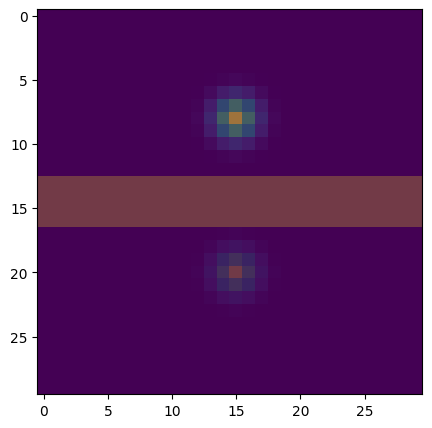

In [2]:
# Define the problem and calculate geodesics
maze = np.zeros((30, 30))
maze[13:17, 0:30] = 1

T = 15
N1 = maze.shape[0]
N2 = maze.shape[1]

H1 = np.repeat(maze[np.newaxis, :, :], T, axis=0) * np.cos(np.pi / 4)
H2 = np.repeat(maze[np.newaxis, :, :], T, axis=0) * np.sin(np.pi / 4)
#H = np.repeat(maze[np.newaxis, :, :], T, axis=0)  # Repeating maze for each time step
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[15./30., 20./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[15./30., 8./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()  

T = 15 # number of time steps
ll = (1.0, 1.0, 1.0) # size of time x space box

xs = []


delta = 2.0

# Wasserstein-Fisher-Rao
x1, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=delta, niter=3000)

#  River constraint
Hs = [[np.zeros((T, N1, N2)), H1, H2, np.zeros((T, N1, N2))]]
GL = [np.zeros((T,))]  
GU = [np.ones((T,)) * np.inf]
x2, lists = computeGeodesic(rho_0, rho_1, T, ll,H=Hs, GL=GL, GU=GU, p= 2.0, q=2.0, delta=delta, niter=3000)

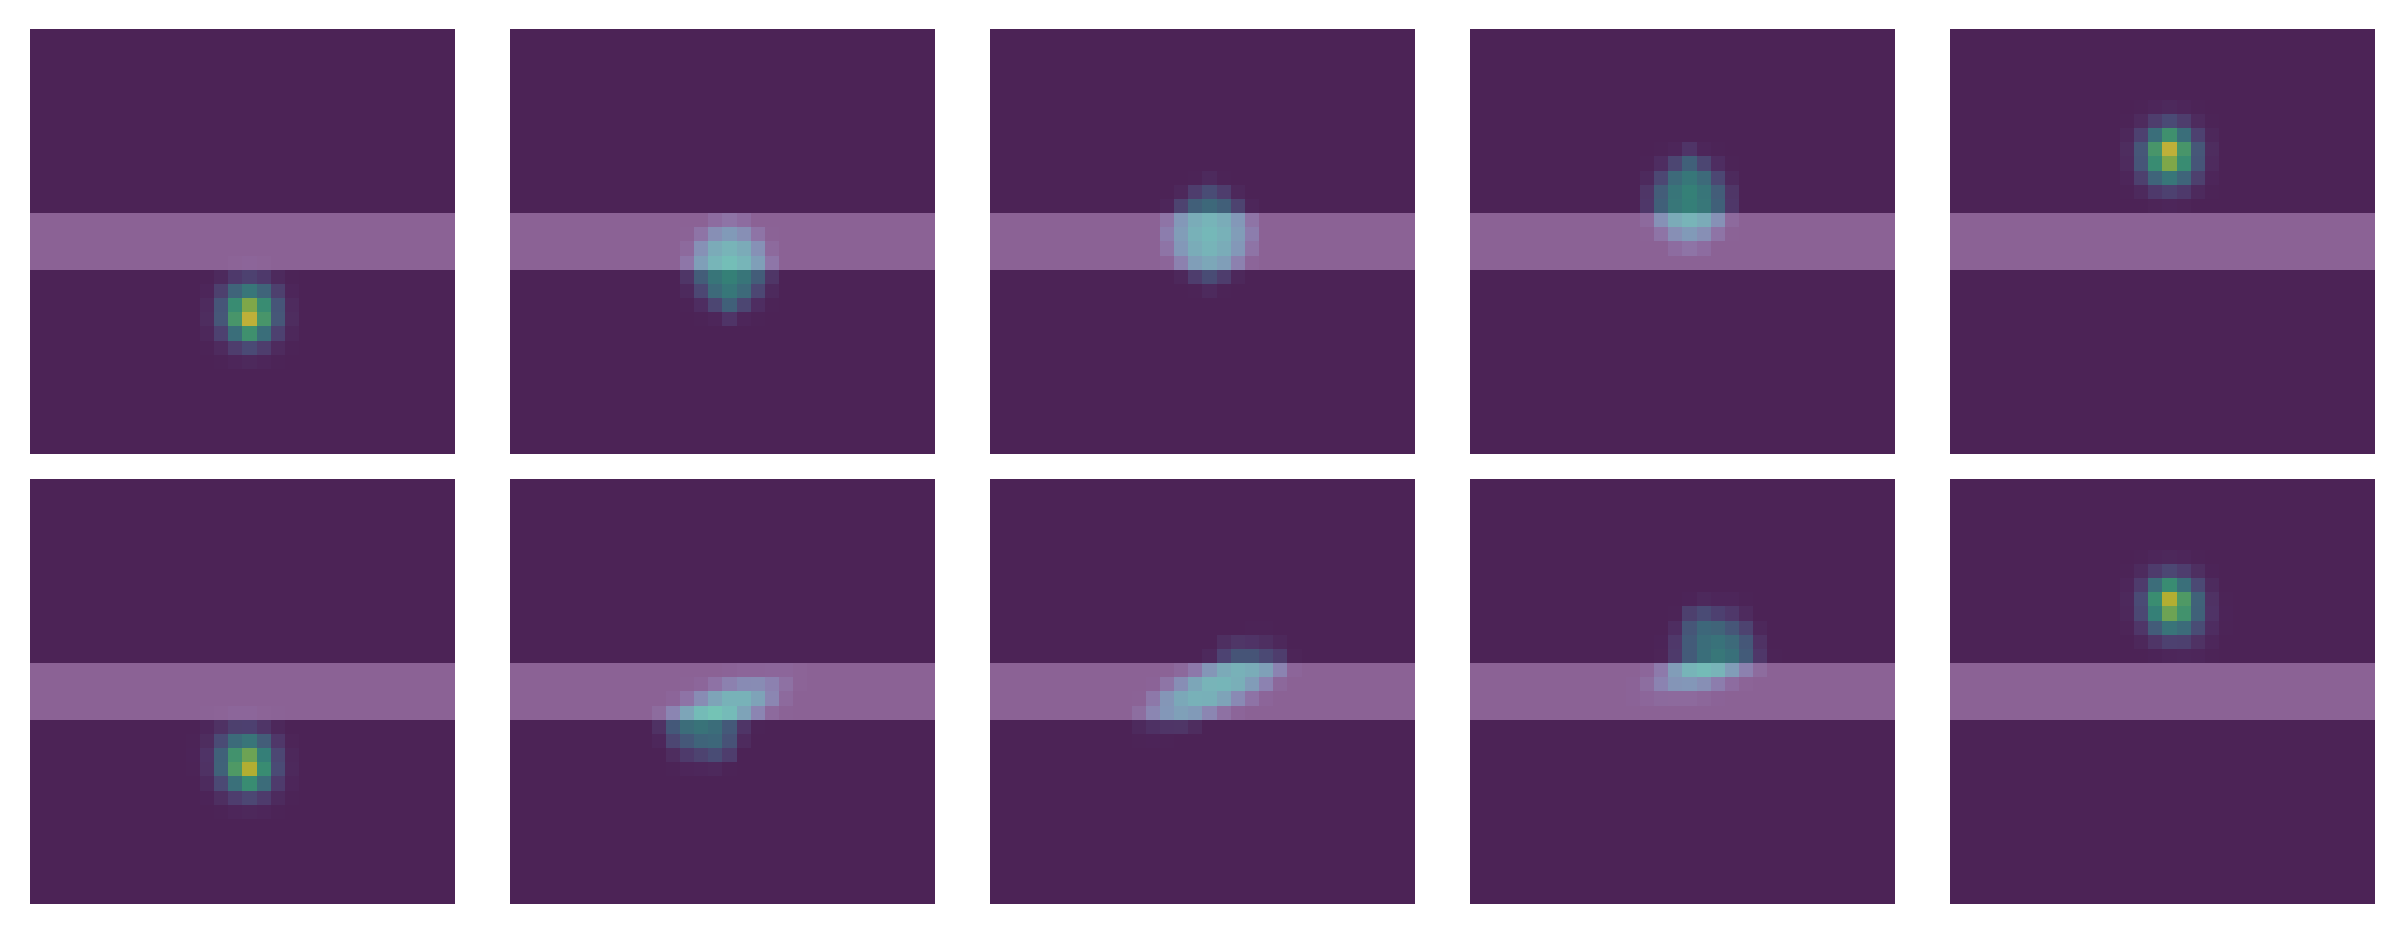

In [3]:
# Plotting the geodesics
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe  # NEW

# --- Style ---
plt.rcParams.update({
    "font.size": 20,
    "axes.titlesize": 20,
    "axes.labelsize": 15,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
})

# Times to show
fractions = [0.0, 0.25, 0.5, 0.75, 1.0]
T_eff = x1.V.D[0].shape[0]
idxs = [int(round(f * (T_eff - 1))) for f in fractions]

# Grid (row=i, col=j)
N1, N2 = maze.shape
YY, XX = np.meshgrid(np.arange(N1), np.arange(N2), indexing="ij")

# Subsample quiver to reduce clutter
step = 2
XXs = XX[::step, ::step]
YYs = YY[::step, ::step]

# Density scaling (shared)
def _max_over(arr, indices):
    return max(np.max(arr.V.D[0][i]) for i in indices)
vmin, vmax = 0.0, max(_max_over(x1, idxs), _max_over(x2, idxs))
cmap = plt.cm.viridis

# --- Momentum: keep image-style orientation (y downward), optional global flip ---
flip_sign = False  # set True if you want to reverse arrow direction
def get_UV(x, t_idx):
    U = x.V.D[2][t_idx]                 # x / columns
    V = x.V.D[1][t_idx]                 # y / rows (no negation; image-style)
    if flip_sign:
        U, V = -U, -V
    return U, V

# Robust arrow scale + outlier clip
def robust_scale_and_clip(target_len=0.40, clip_pct=99.0):
    mags = []
    for x in (x1, x2):
        for t in idxs:
            U, V = get_UV(x, t)
            M = np.hypot(U[::step, ::step], V[::step, ::step])
            if M.size:
                mags.append(M.ravel())
    M_all = np.concatenate(mags) if mags else np.array([1.0])
    m95   = np.percentile(M_all[M_all > 0], 95) if np.any(M_all > 0) else 1.0
    mcap  = np.percentile(M_all, clip_pct)
    scale = max(m95 / target_len, 1e-12)
    return scale, mcap

qscale, mcap = robust_scale_and_clip(target_len=0.40, clip_pct=99.0)
eps = 1e-12

# Arrow appearance
ARROW_WIDTH = 0.0050
HEAD_W, HEAD_L, HEAD_AX = 10.0, 12.0, 9.0

# --- Figure: 2 rows (Unconstrained / Constrained) × 5 columns (times) ---
fig, axes = plt.subplots(2, len(idxs), figsize=(8, 3), dpi=300, constrained_layout=True)

cmap = plt.cm.viridis
density_alpha = 0.82            # NEW: slightly fade density
ARROW_FACE = "white"            # NEW: high-contrast arrow face
ARROW_EDGE = "black"            # NEW: thin black outline
ARROW_LINEWIDTH = 0.6           # NEW

def draw_row(axrow, x, row_label, show_titles=False):
    for j, t_idx in enumerate(idxs):
        ax = axrow[j]

        # 1) Density (slightly translucent so arrows stand out)
        rho = x.V.D[0][t_idx]
        dens = ax.imshow(
            rho, vmin=vmin, vmax=vmax, cmap=cmap,
            origin="upper",
            extent=[-0.5, N2-0.5, N1-0.5, -0.5],
            interpolation="nearest",
            alpha=density_alpha,               # << here
            zorder=1
        )

        # Maze overlay
        ax.imshow(
            maze, cmap="gray", alpha=0.25, origin="upper",
            extent=[-0.5, N2-0.5, N1-0.5, -0.5], interpolation="nearest",
            zorder=2
        )

        # 2) Momentum (quiver) with white fill + black outline
        U, V = get_UV(x, t_idx)
        Us = U[::step, ::step].copy(); Vs = V[::step, ::step].copy()
        M  = np.hypot(Us, Vs)
        clip_fac = np.minimum(1.0, mcap / (M + eps))
        Us *= clip_fac; Vs *= clip_fac

        rho_s = rho[::step, ::step]
        support = rho_s > (0.003 * rho_s.max())
        Us = np.where(support, Us, 0.0)
        Vs = np.where(support, Vs, 0.0)

        """
        q = ax.quiver(
            XXs, YYs, Us, Vs,
            angles="xy", scale_units="xy", scale=qscale,
            pivot="tail", width=ARROW_WIDTH,
            headwidth=HEAD_W, headlength=HEAD_L, headaxislength=HEAD_AX,
            color=ARROW_FACE,                 # white fill
            linewidths=ARROW_LINEWIDTH,       # edge thickness
            zorder=3
        )

        # Style the single Quiver artist (no .collections here)
        q.set_edgecolor(ARROW_EDGE)           # black outline
        q.set_facecolor(ARROW_FACE)           # keep white fill
        q.set_linewidths(ARROW_LINEWIDTH)

        # Optional: extra crisp outline (works on Collections/Artists)
        q.set_path_effects([
            pe.withStroke(linewidth=ARROW_LINEWIDTH + 0.6, foreground=ARROW_EDGE)
        ])
        """

        # Cosmetics
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(-0.5, N2-0.5); ax.set_ylim(N1-0.5, -0.5)
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)

        if show_titles:
            ax.set_title(f"t = {fractions[j]:.2f}", pad=6)
    #axrow[0].set_ylabel(row_label)

# Draw rows
draw_row(axes[0], x1, "Unconstrained", show_titles=False)
draw_row(axes[1], x2, "Constrained",   show_titles=False)

# Shared colorbar for density
#mappable = axes[1, -1].images[0]  # the density image on the last subplot
#cbar = fig.colorbar(mappable, ax=axes.ravel().tolist(), fraction=0.03, pad=0.02)
#cbar.set_label("Density")

# Save
plt.savefig("figures/012-river.png", bbox_inches="tight", dpi=300)
#plt.savefig("figures/river_uot_merged_density_quiver_2x5.pdf", bbox_inches="tight")
plt.show()


Here, the top is an unconstrained geodesic and the bottom is a constrained geodesic.

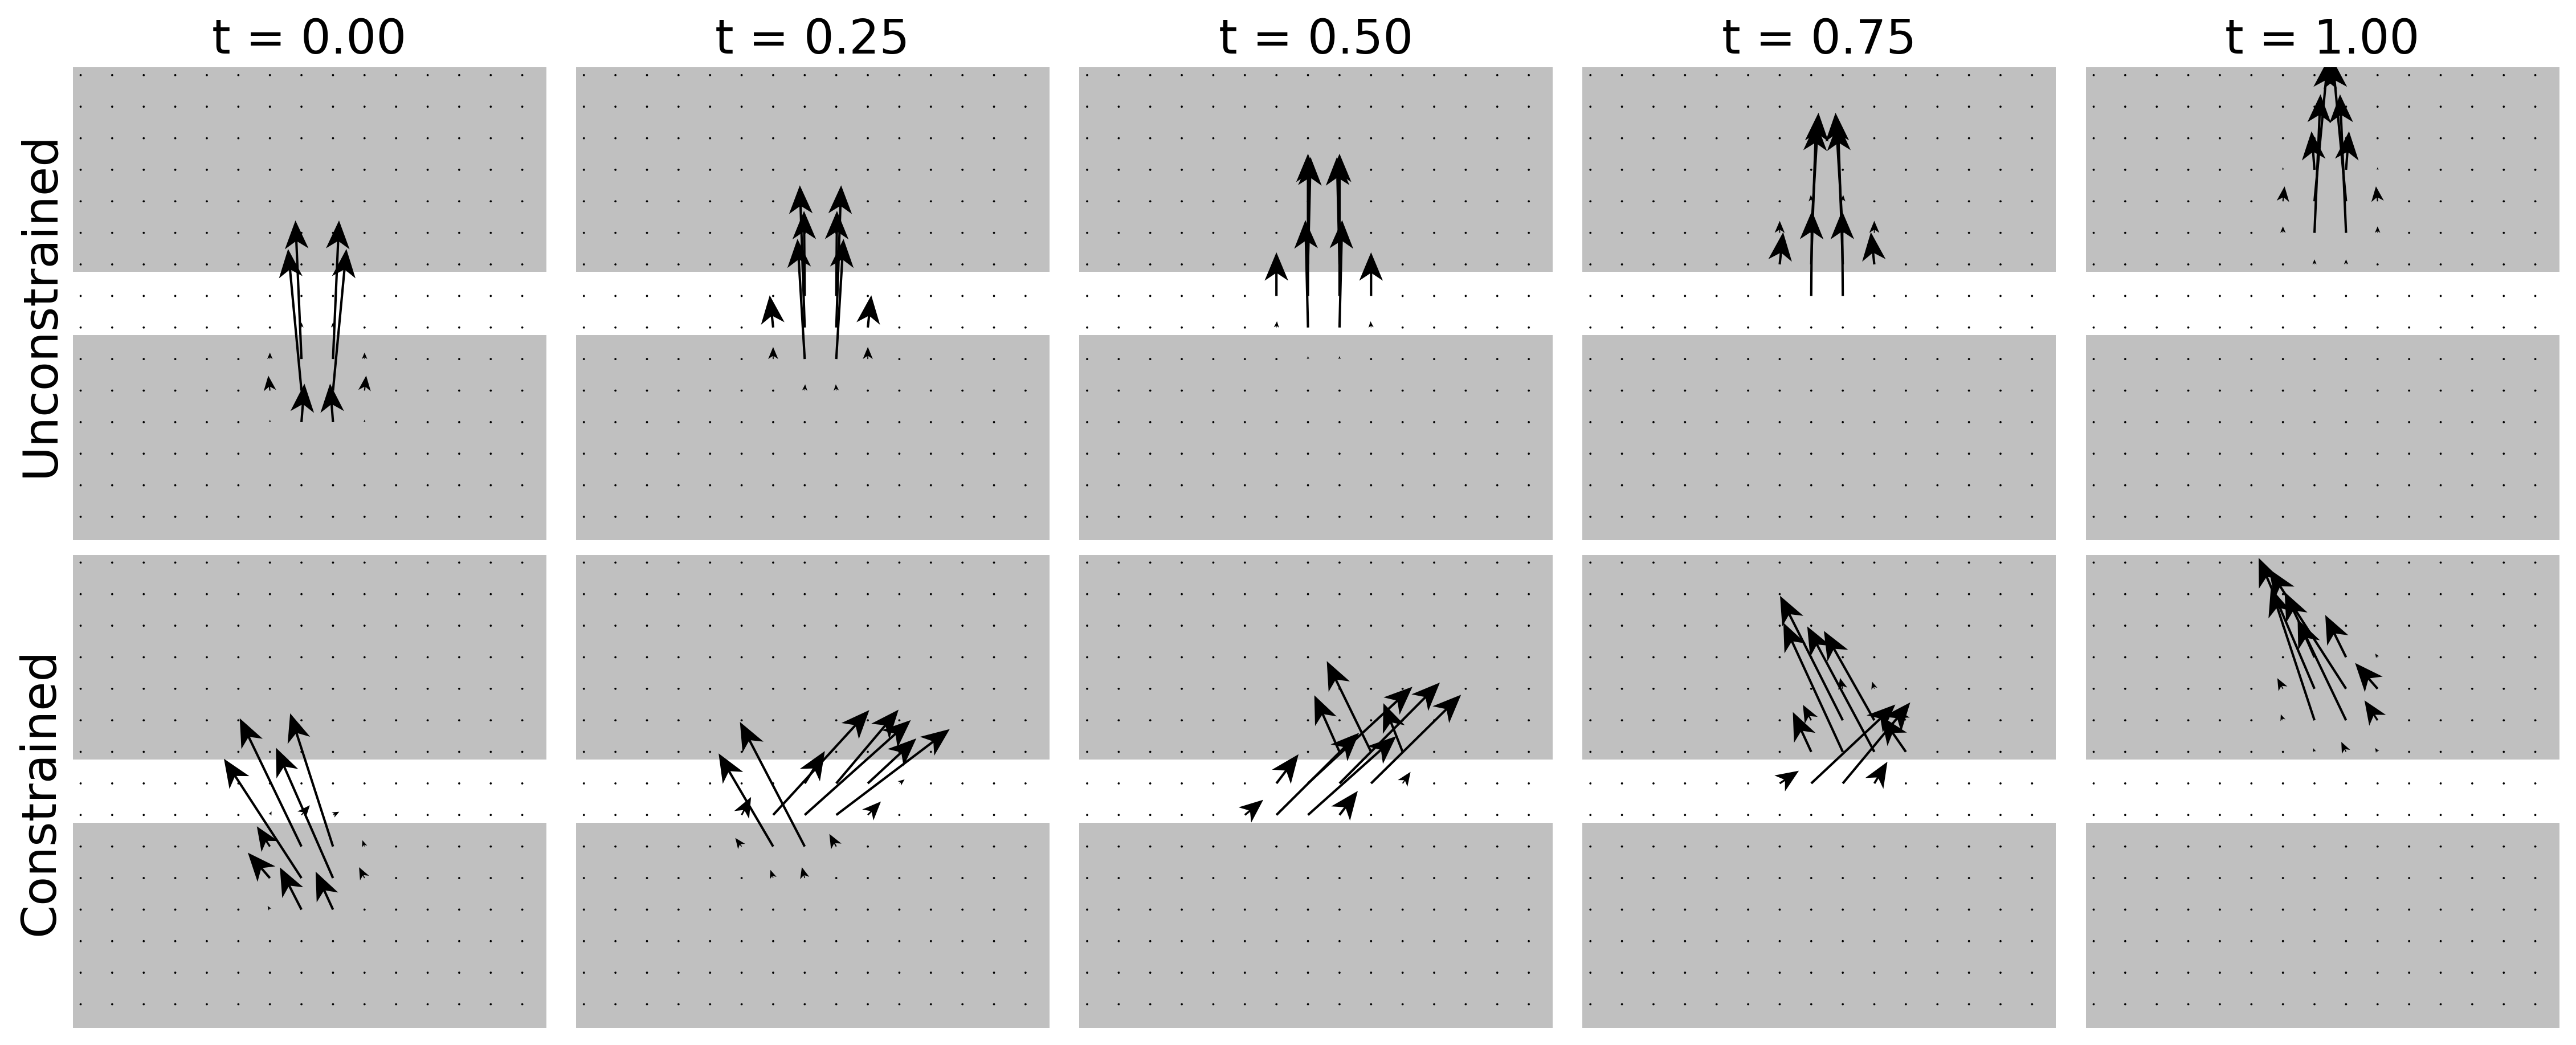

In [4]:
# Plot the momentum fields as quiver plots
import numpy as np
import matplotlib.pyplot as plt

# --- Style ---
plt.rcParams.update({
    "font.size": 20,
    "axes.titlesize": 20,
    "axes.labelsize": 20,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
})

fractions = [0.0, 0.25, 0.5, 0.75, 1.0]
T_eff = x1.V.D[0].shape[0]
idxs = [int(round(f * (T_eff - 1))) for f in fractions]

# Grid aligned with pixel centers (row=i, col=j)
N1, N2 = maze.shape
YY, XX = np.meshgrid(np.arange(N1), np.arange(N2), indexing="ij")

# Subsample to reduce clutter
step = 2
XXs = XX[::step, ::step]
YYs = YY[::step, ::step]

# --- Direction: keep sign flip, restore original (image) orientation ---
flip_sign = False  # keep this True per your preference

def get_UV(x, t_idx):
    U = x.V.D[2][t_idx]   # x/columns
    V = x.V.D[1][t_idx]   # y/rows (no negation; y points downward like rows)
    if flip_sign:
        U, V = -U, -V
    return U, V

# Robust scale & outlier clip
def robust_scale_and_clip(target_len=0.40, clip_pct=99.0):
    mags = []
    for x in (x1, x2):
        for t in idxs:
            U, V = get_UV(x, t)
            M = np.hypot(U[::step, ::step], V[::step, ::step])
            if M.size:
                mags.append(M.ravel())
    M_all = np.concatenate(mags) if mags else np.array([1.0])
    m95   = np.percentile(M_all[M_all > 0], 95) if np.any(M_all > 0) else 1.0
    mcap  = np.percentile(M_all, clip_pct)
    scale = max(m95 / target_len, 1e-12)
    return scale, mcap

qscale, mcap = robust_scale_and_clip(target_len=0.40, clip_pct=99.0)
eps = 1e-12

# Bigger, clearer arrowheads
ARROW_WIDTH = 0.0050
HEAD_W, HEAD_L, HEAD_AX = 10.0, 12.0, 9.0

def draw_row(axrow, x, row_label):
    for j, t_idx in enumerate(idxs):
        ax = axrow[j]
        U, V = get_UV(x, t_idx)

        # Subsample & clip extremes
        Us = U[::step, ::step].copy()
        Vs = V[::step, ::step].copy()
        M  = np.hypot(Us, Vs)
        clip_fac = np.minimum(1.0, mcap / (M + eps))
        Us *= clip_fac; Vs *= clip_fac

        # Optional: only where density is non-negligible
        rho = x.V.D[0][t_idx][::step, ::step]
        support = rho > (0.003 * rho.max())
        Us = np.where(support, Us, 0.0)
        Vs = np.where(support, Vs, 0.0)

        # Background with original (image) orientation: top-left is (0,0), y goes downward
        ax.imshow(
            maze, cmap="gray", alpha=0.25, origin="upper",
            extent=[-0.5, N2-0.5, N1-0.5, -0.5], interpolation="nearest"
        )

        ax.quiver(
            XXs, YYs, Us, Vs,
            angles="xy", scale_units="xy", scale=qscale,
            pivot="tail", width=ARROW_WIDTH,
            headwidth=HEAD_W, headlength=HEAD_L, headaxislength=HEAD_AX
        )

        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(-0.5, N2-0.5)
        ax.set_ylim(N1-0.5, -0.5)  # reversed order → image-style orientation
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)
    axrow[0].set_ylabel(row_label)

fig, axes = plt.subplots(2, len(idxs), figsize=(15, 6), dpi=300, constrained_layout=True)
draw_row(axes[0], x1, "Unconstrained")
draw_row(axes[1], x2, "Constrained")
for j, f in enumerate(fractions):
    axes[0, j].set_title(f"t = {f:.2f}", pad=6)

plt.savefig("figures/013-river-momentum.png", bbox_inches="tight", dpi=300)


# Budget Constraint
Here, we will consider the constraint
$$ 0 \leq \int_{\Omega} H(t,x)d\zeta(x) \leq 0.1$$
where $H(t, x) = 1$ where the deletion of the mass is prohibited and creation is highly prohibited (say due to the budget). In this example, we have a 1D domain and the initial mass is placed left and the terminal mass is placed right. Moreover we set delta to be small to encourage creation/destruction. However, we impose the above constraint on the right half of the domain, essentially disallowing teleportation of mass. We will observe the change of the behavior in solution.

In [6]:
# Import necessary libraries and define functions
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from proximal.dynamicUOT import computeGeodesic, computeGeodesic_inequality
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact


def gauss(x, x_0, sigma, mass, K):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

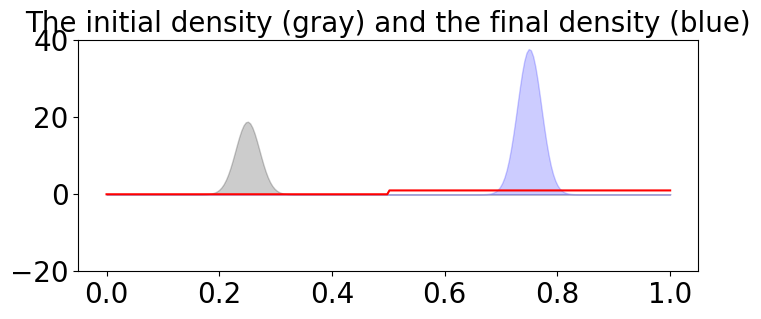

Solution saved to results\budget.npz


In [ ]:
# Define the problem and calculate geodesics

# Plotting initial and the final density
sigma = 0.03
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

rho_0 = gauss(X, 0.25, sigma, 1, K) # Initial density
rho_1 = gauss(X, 0.75, sigma, 1, K)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 256 # make sure the total mass is 1
rho_1 /= np.sum(rho_1) / (256 * 2)

rho_0.dtype = np.float64
rho_1.dtype = np.float64

# Plotting
plt.figure(figsize=(8, 3))
plt.ylim(-20, 40)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
H = np.zeros((K,))
H[128:] = 1.0
plt.plot(X, H, color="r", label="H")
plt.show()


T = 15                     # number of time steps (midpoints at (i+0.5)/T)
ll = (1.0, 1.0)            # time x space box size

time_mid = np.array([(i + 0.5) / T for i in range(T)])

xs = []

# WFR baseline
delta = 0.5/np.pi
x, _lists = computeGeodesic(rho_0, rho_1, T, ll, p=2.0, q=2.0, delta=delta, niter=3000)
xs.append(x)

H_start_index = None      # e.g., 128 for "right half"; set to an int or leave None
H_start_x     = 0.5       # e.g., 0.5 for "right half"; set to a float in [0,1] or None

# Determine spatial resolution (K) from the baseline geodesic
K = xs[0].U.D[0].shape[1]           # number of spatial cells on the centered grid

if H_start_index is not None:
    j0 = int(np.clip(H_start_index, 0, K-1))
else:
    # default to coordinate specification
    if H_start_x is None:
        H_start_x = 0.5
    # map x in [0,1] to a cell index on the centered grid
    j0 = int(np.floor(H_start_x * K))
    j0 = int(np.clip(j0, 0, K-1))

# Build step mask: H=0 on [0, j0), H=1 on [j0, K)
H_vec = np.zeros((K,), dtype=float)
H_vec[j0:] = 1.0
H = np.tile(H_vec, (T, 1))          # repeat across time: shape (T, K)

# ζ-constrained (regional production cap)
Hs = [[np.zeros((T, K)), np.zeros((T, K)), H]]   # (Hρ, Hω, Hζ)
GL = [np.zeros((T,))]
GU = [0.1 * np.ones((T,))]                       # capacity schedule (example)
x, _lists = computeGeodesic(
    rho_0, rho_1, T, ll,
    H=Hs, GL=GL, GU=GU,
    p=2.0, q=2.0, delta=delta, niter=3000,
)
xs.append(x)

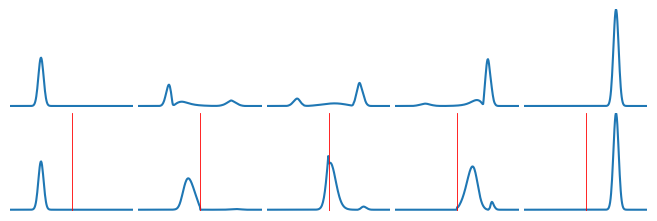

In [13]:
# Plotting the geodesics

# --- Extract ρ, ω-speed, ζ-growth on the centered grid ------------------------
Ds, vs, gs = [], [], []
for x in xs:
    Ds.append(x.U.D[0])                 # ρ over time×space (T × Nx)
    v, g = speed_and_growth(x.V, 100)   # returns |ω| and ζ on centered grid
    vs.append(v[0])                     # |ω|
    gs.append(g)                        # ζ

# Grids (adjust Nx if needed)
Nx = Ds[0].shape[1]
x_grid = (np.arange(Nx) + 0.5) / Nx

# --- Choose five display times ≈ (0, .25, .5, .75, 1) -------------------------
targets = np.array([0.00, 0.25, 0.50, 0.75, 1.00])
idx = np.clip(np.round(T * targets).astype(int), 0, T)

# --- Fixed y-limits across ALL panels (ρ only here) ---------------------------
glob_min, glob_max = np.inf, -np.inf
for r in range(len(xs)):
    glob_min = min(glob_min, Ds[r].min())
    glob_max = max(glob_max, Ds[r].max())

ymin, ymax = glob_min - 0.5, glob_max
if ymin == ymax:
    ymin, ymax = ymin - 1.0, ymax + 1.0

# --- Compact 2×5 panel figure (no legends, ticks, labels, or spines) ----------
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(6.5, 2.1), sharex=True, sharey=True)

# Style for ρ (keep grayscale-friendly; no legend)
rho_style = dict(linestyle='solid', linewidth=1.5)

# Optional: mark where H jumps to 1 (off by default to keep the figure pristine)
mark_H_start = True
x_H_start = x_grid[j0]  # physical coordinate of the jump

for c, i in enumerate(idx):
    for r in range(rows):
        ax = axes[r, c]
        ax.plot(x_grid, Ds[r][i, :], **rho_style)

        if mark_H_start and r > 0:
            ax.axvline(x_H_start, linewidth=0.6, color='red')

        ax.set_xlim(0, 1)
        ax.set_ylim(ymin, ymax)

        # Remove anything graphical besides the curves
        ax.set_xticks([])
        ax.set_yticks([])
        for s in ('top', 'right', 'left', 'bottom'):
            ax.spines[s].set_visible(False)

# Tight layout with minimal padding; no titles/supertitles
fig.subplots_adjust(left=0.01, right=0.99, bottom=0.02, top=0.98, wspace=0.04, hspace=0.06)

# Save as vector PDF (for the paper) and a high-DPI PNG (for quick looks)
fig.savefig("figures/014-budget.png", dpi=600, bbox_inches="tight", pad_inches=0.01)

plt.show()

plt.close(fig)


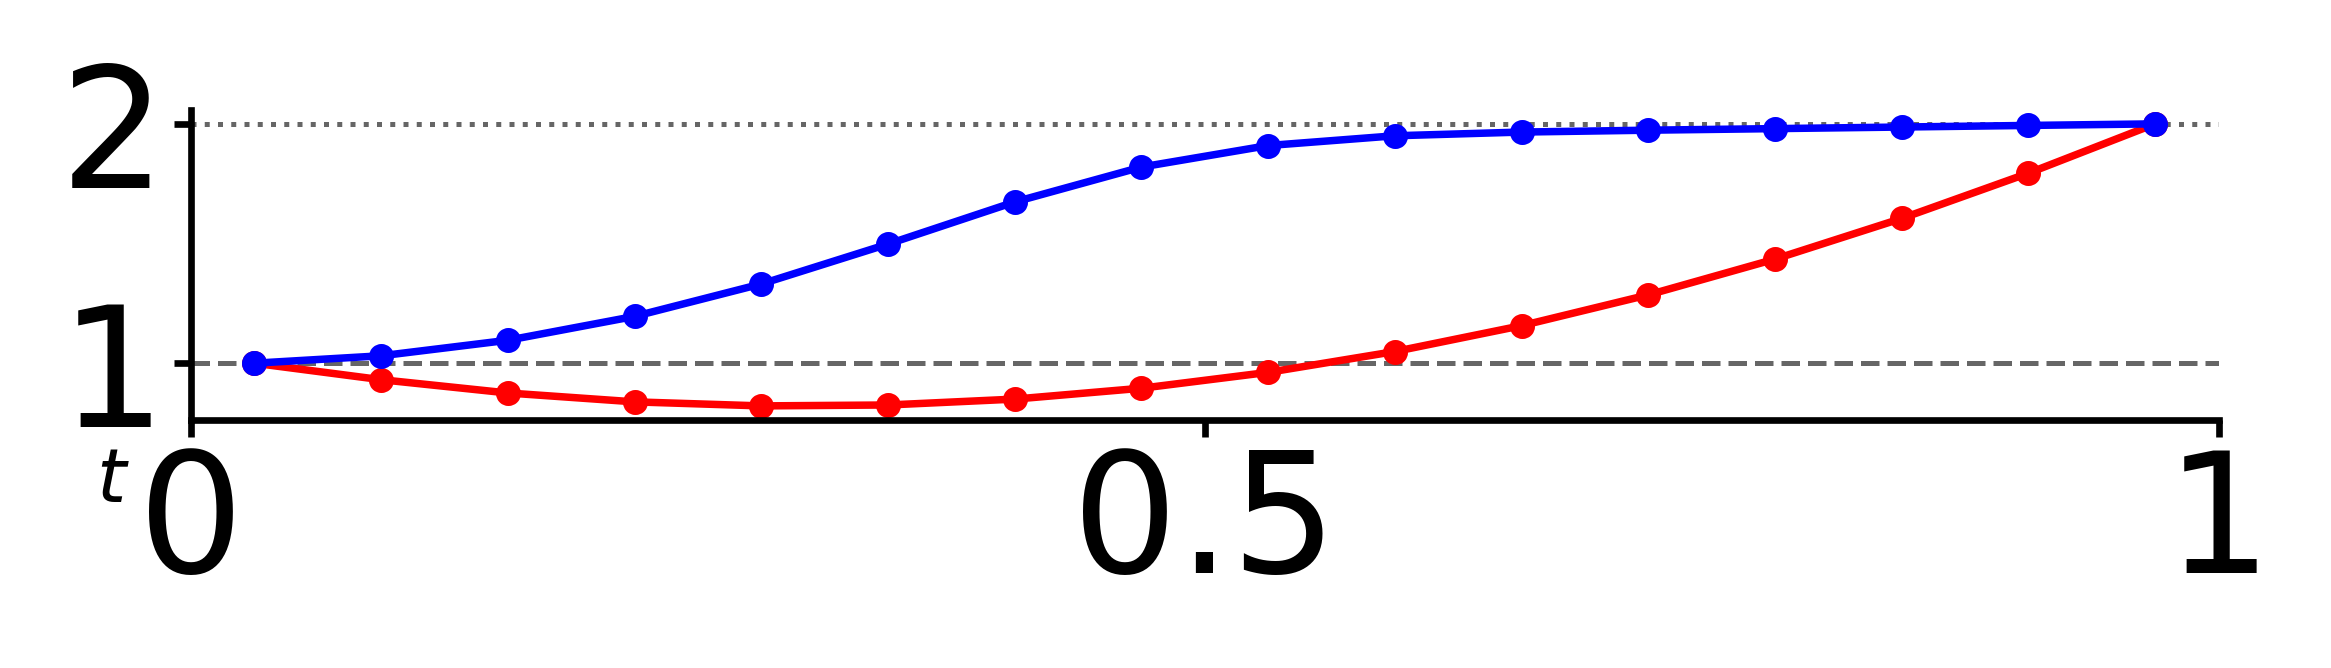

In [12]:
# Plotting the total mass over time
# --------------------------------------------------------------
#  Exact‑pixel “total mass vs t” figure: 2211 px × 408 px
# --------------------------------------------------------------
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# -------- inputs from your session -----------------------------
# Expect: Ds is a list of arrays (one per solution) with shape (Nt, Nx).
# If Ds isn't defined yet, fall back to xs -> Ds.
try:
    Ds  # noqa: F821
except NameError:
    Ds = [x.U.D[0] for x in xs]  # one density time-series per solution

Nt, Nx = Ds[0].shape
# Time at cell centers: (i+0.5)/Nt in [0,1]
t = np.linspace(0, 1, Nt, endpoint=False) + 0.5 / Nt

# Total mass curves: discrete integral over space
mass_curves = [D.sum(axis=1) / Nx for D in Ds]

# -------- figure geometry for 2211×408 px at 600 dpi -----------
dpi_out         = 600
fig_width_inch  = 2211 / dpi_out - 0.09    # small fudge to compensate tight bbox
fig_height_inch =  408 / dpi_out - 0.124   # idem

rcParams.update({"font.size": 8, "text.usetex": False})

# Choose as many colors as needed; we’ll plot len(Ds) curves.
colours = ["red", "blue"]

fig = plt.figure(figsize=(fig_width_inch, fig_height_inch),
                 dpi=dpi_out, facecolor="white")
ax  = fig.add_axes([0.03, 0.04, 0.94, 0.93])  # fill almost everything

# -------- plot -------------------------------------------------
for m, c in zip(mass_curves, colours):
    ax.plot(t, m, marker='o', ms=2, lw=0.9, color=c)

# Reference lines (optional; helpful when masses hover near 1)
ax.axhline(1.0, color="0.4", lw=0.6, ls="--", zorder=0)
ax.axhline(2.0, color="0.4", lw=0.6, ls=":",  zorder=0)

# -------- axes cosmetics --------------------------------------
# Auto y-limits with a bit of headroom
ymin = min(float(m.min()) for m in mass_curves)
ymax = max(float(m.max()) for m in mass_curves)
pad  = 0.05 * (ymax - ymin if ymax > ymin else 1.0)

ax.set_xlim(0, 1)
ax.set_ylim(ymin - pad, ymax + pad)

ax.set_xticks([0, 0.5, 1]); ax.set_xticklabels(["0", "0.5", "1"])
# Show 0.8 and 1.0 ticks if they fall inside the plotted range
yticks = []
yticks.append(1.0)
yticks.append(2.0)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{v:g}" for v in yticks])

ax.tick_params(axis="both", direction="out", length=2, pad=1)
for s in ("right", "top"):
    ax.spines[s].set_visible(False)

# Tiny “t” label just left of the x‑axis origin
ax.text(-0.03, -0.08, r"$t$", transform=ax.transAxes,
        ha="right", va="top", fontsize=9)

# -------- save -------------------------------------------------
os.makedirs("figures", exist_ok=True)
fig.savefig("figures/015-budget-total-mass.png",
            dpi=dpi_out, bbox_inches="tight", pad_inches=0, transparent=True)
plt.show()
plt.close(fig)
